In [1]:
import Pkg; Pkg.activate("../"); # Activate the project 

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [19]:
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Plots", "LaTeXStrings", "Statistics", "OrdinaryDiffEq", "ProgressMeter", "CSV", "DataFrames"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

Installing DataFrames...


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed InvertedIndices ──── v1.3.1
   Installed PrettyTables ─────── v2.4.0
   Installed StringManipulation ─ v0.4.0
   Installed DataFrames ───────── v1.7.0
    Updating `~/Documents/Research/MonitoringMetrology/QuTaM.jl/Project.toml`
  [a93c6f00] + DataFrames v1.7.0
    Updating `~/Documents/Research/MonitoringMetrology/QuTaM.jl/Manifest.toml`
 [a8cc5b0e] + Crayons v4.1.1
  [a93c6f00] + DataFrames v1.7.0
  [41ab1584] + InvertedIndices v1.3.1
  [08abe8d2] + PrettyTables v2.4.0
  [892a3eda] + StringManipulation v0.4.0
Precompiling project...
  ✓ InvertedIndices
  ✓ StringManipulation
  ✓ PrettyTables
  ✓ DataFrames
  4 dependencies successfully precompiled in 63 seconds. 266 already precompiled.


In [3]:
H_parametrized = (delta::Float64, gamma::Float64) -> (0.5*delta*QuTaM.sigma_z)::Matrix{ComplexF64}
L_parametrized = (delta::Float64, gamma::Float64) -> (sqrt(gamma)*QuTaM.sigma_m)::Matrix{ComplexF64}
# Function that constructs returns a parametrization of the effective hamiltonian from 
# the parametrization of the hamiltonian and the jump operators


#3 (generic function with 1 method)

In [3]:
function GetHeffParametrized(H_par::Function, Ls_par)::Function
    return (input...) -> begin
        LLs_par = [ adjoint(L_par(input...))*L_par(input...) for L_par in Ls_par]
        return H_par(input...) - 0.5im*sum(LLs_par)  
    end 
end 

GetHeffParametrized (generic function with 1 method)

In [4]:
function DerivativeExpHeff(Heff_par::Function, tau::Float64, theta::Vector{Float64}, dtheta::Vector{Float64})
    f1 =  exp(-1im*tau*Heff_par((theta + 2*dtheta)...))
    f2 =  exp(-1im*tau*Heff_par((theta + 1*dtheta)...))
    f3 =  exp(-1im*tau*Heff_par((theta - 1*dtheta)...))
    f4 =  exp(-1im*tau*Heff_par((theta - 2*dtheta)...))
    return (-f1 + 8*f2 - 8*f3 + f4 )/(12*norm(dtheta))
end 

function DerivativesAtJumps(sys::System, Heff_par::Function, Ls_par, traj::Trajectory, psi0::Vector{ComplexF64}, theta::Vector{Float64},
                            dtheta::Vector{Float64})
    # 0. Special Case: if the trajectory is empty, return an empty array
    if isempty(traj)
        return Array{ComplexF64}(undef, 0, 0) 
    end
    # 1. Get the derivatives of L
    nchannels = size(Ls_par)[1]
    dLs = zeros(ComplexF64, sys.NLEVELS, sys.NLEVELS, nchannels)
    
    for k in 1:nchannels
        f1 = Ls_par[k]((theta + 2*dtheta)...) 
        f2 = Ls_par[k]((theta+dtheta)...) 
        f3 = Ls_par[k]((theta-dtheta)...)
        f4 = Ls_par[k]((theta-2*dtheta)...)
        dLs[:, :, k] = (-f1 + 8*f2 - 8*f3 + f4 )/(12*norm(dtheta))
    end 
    # 2.1 Setup 
    njumps = size(traj)[1]
    dpsis = zeros(ComplexF64, sys.NLEVELS, njumps)
    # 2.2 Set up the first jump
    click = traj[1] 
    label = click.label
    tau = click.time
    dpsis[:, 1] .= dLs[:, :, label] * exp(-1im*tau*sys.Heff) * psi0 +
                      sys.Ls[label] * DerivativeExpHeff(Heff_par, tau, theta, dtheta) * psi0 # Derivative
    # In case there are no more jumps, return
    if njumps  == 1 
        return dpsis
    end  
    # 3. Go over the rest of the jumps 
    psitildes = states_at_jumps(traj, sys, psi0; normalize=false)
    for k in 2:njumps 
      click = traj[k] 
      label = click.label
      tau = click.time
      # Calculate the derivative
      dpsis[:, k] .= begin 
                     (dLs[:, :, label]) * exp(-1im*tau*sys.Heff) * psitildes[:, k-1] +
                     sys.Ls[label] * DerivativeExpHeff(Heff_par, tau, theta, dtheta) * psitildes[:, k-1] + # Derivative
                     sys.Ls[label] * exp(-1im*tau*sys.Heff) * dpsis[:, k -1]
                     end
   end 
   return dpsis 
    
end 



DerivativesAtJumps (generic function with 1 method)

In [13]:
Heff_parametrized = GetHeffParametrized(H_parametrized, [L_parametrized])
sys = QuTaM.rd_sys 
traj = [DetectionClick(0.1, 1)]
psi0 = [0.0 + 0im, 1.0+ 0im]
DerivativesAtJumps(sys, Heff_parametrized, [L_parametrized], traj, psi0, 
                    [QuTaM.rd_deltaomega, QuTaM.rd_gamma], [0.0, QuTaM.rd_gamma/100])

2×1 Matrix{ComplexF64}:
 0.17355820485444767 - 0.01129719801926627im
                 0.0 + 0.0im

In [15]:
0.5/sqrt(QuTaM.rd_gamma) * exp(-1im*traj[1].time*(0.5*QuTaM.rd_deltaomega - 0.5im*QuTaM.rd_gamma)) +
sqrt(QuTaM.rd_gamma)*(-0.5*traj[1].time)*exp(-1im*traj[1].time*(0.5*QuTaM.rd_deltaomega - 0.5im*QuTaM.rd_gamma))

0.17355820539697653 - 0.011297198054579793im

In [5]:
function MonitoringOperator(t_given::Vector{Float64}, 
    sys::System, Heff_par::Function, Ls_par, traj::Trajectory, psi0::Vector{ComplexF64}, theta::Vector{Float64},
                            dtheta::Vector{Float64})
 
    # Special case: if the time array is empty, return an empty array
    if isempty(t_given)
        return Array{ComplexF64}(undef, 0, 0, 0)
    end
    psi = evaluate_at_t(t_given, traj, sys, psi0; normalize=false)
    ntimes = size(t_given)[1]
    njumps = size(traj)[1]
    t_ = 0
    counter = 1
    counter_c = 1
    xis = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes)
    # Edge case
    if isempty(traj)
        while counter <= ntimes
            tmp = DerivativeExpHeff(Heff_par, t_given[counter], theta, dtheta) * psi0
            xis[:, :, counter] = (adjoint(tmp) .* psi[:, counter] +  adjoint(psi[:, counter]) .* tmp)/dot(psi[:, counter], psi[:,counter])
            counter = counter + 1
            if counter > ntimes
                break
            end
        end
        return states
    end
    # Evaluations before first jump
    while (t_given[counter] < traj[counter_c].time) && (counter <= ntimes)
            tmp = DerivativeExpHeff(Heff_par, t_given[counter], theta, dtheta) * psi0
            xis[:, :, counter] = (adjoint(tmp) .* psi[:, counter] +  adjoint(psi[:, counter]) .* tmp)/dot(psi[:, counter], psi[:, counter])
            counter = counter + 1
            if counter > ntimes
                break
            end
    end
    dpsijumps = DerivativesAtJumps(sys, Heff_par, Ls_par, traj, psi0, theta, dtheta)
    psijumps = states_at_jumps(traj, sys, psi0; normalize=false)
    t_ = t_ + traj[counter_c].time
    counter_c = counter_c + 1
    # Evaluation after first jump
    while (counter_c <= njumps) && (counter <= ntimes)
        timeclick = traj[counter_c].time
        while (t_ < t_given[counter] < t_ + timeclick) && (counter <= ntimes)
            tmp = (DerivativeExpHeff(Heff_par, t_given[counter]-t_, theta, dtheta) * psijumps[:, counter_c-1]+
                   exp(-1im*(t_given[counter]-t_)*sys.Heff)*dpsijumps[:, counter_c-1] ) 
            xis[ :, :,counter] = (adjoint(tmp) .* psi[ :, counter] +  adjoint(psi[:, counter]) .* tmp)/dot(psi[:, counter], psi[:, counter])
            counter = counter + 1
            if counter > ntimes
                break
            end
         end
       t_ = t_ + timeclick
       counter_c = counter_c + 1
    end

    while counter <= ntimes
        tmp = (DerivativeExpHeff(Heff_par, t_given[counter]-t_, theta, dtheta) * psijumps[:, njumps]+
                   exp(-1im*(t_given[counter]-t_)*sys.Heff)*dpsijumps[:, njumps] )
        xis[ :, :,counter] = (adjoint(tmp) .* psi[ :, counter] +  adjoint(psi[:, counter]) .* tmp)/dot(psi[:, counter], psi[:, counter])
        counter = counter + 1
    end
    return xis
end




MonitoringOperator (generic function with 1 method)

In [39]:
sys = QuTaM.rd_sys 
params = SimulParameters(QuTaM.rd_psi0,
    3.0, # Final time. Set very long so that all trajectories jump
    1, # seed
    1000, # Number of trajectories
    50_000, # Number of samples in the finegrid
    10.5, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)


SimulParameters(psi0=ComplexF64[0.0 + 0.0im, 1.0 + 0.0im]
nsamples=50000
seed=1
ntraj=1000)
multiplier=10.5
tf=3.0
dt=0.00063
eps=0.001)

In [40]:
trajectories = run_trajectories(sys, params);

Sampling... 100%|██████████████████████████| Time: 0:00:26 (26.14 ms/it)


# Radiative Damping

In [41]:
ntimes = 100
t_given = collect(LinRange(0, params.tf, ntimes));

In [42]:
z_sample = Array{Float64}(undef, ntimes, params.ntraj)
states = Array{ComplexF64}(undef, sys.NLEVELS, ntimes, params.ntraj)
# Set states
for k in 1:params.ntraj
    states[:, :, k] = evaluate_at_t(t_given, trajectories[k], sys, params.psi0)
end 
for k in 1:params.ntraj
    for tn in 1:ntimes
        z_sample[tn, k] = real(dot(states[:, tn, k], QuTaM.sigma_z * states[:, tn, k]))
    end 
end 
z_avg = dropdims(mean(z_sample, dims=2), dims=2);


In [43]:
# Analytical resul
z_an(t) = 2*Base.MathConstants.e^(-QuTaM.rd_gamma*t) - 1

z_an (generic function with 1 method)

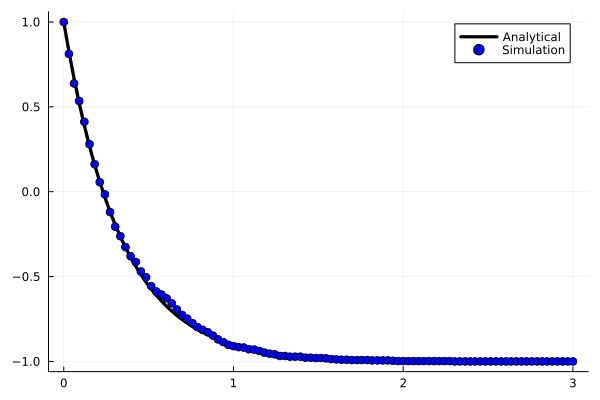

In [44]:
plot(t_given, z_an.(t_given), label="Analytical", linewidth=3.3, color="black")
scatter!(t_given, z_avg, label="Simulation", color="blue", markersize=4.3)

In [45]:
xi_sample = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes, params.ntraj)
for n in 1:params.ntraj
    xi_sample[:, :, :, n] = MonitoringOperator(t_given, sys, Heff_parametrized, [L_parametrized], trajectories[n], params.psi0,
                           [QuTaM.rd_deltaomega, QuTaM.rd_gamma], [0.0, QuTaM.rd_gamma/100])
end 

In [46]:
fi_sample = Array{Float64}(undef, ntimes, params.ntraj)
for n in 1:params.ntraj
    for k in 1:ntimes
       fi_sample[k, n] = real(tr(xi_sample[:, :, k, n]))^2 
    end 
end 

In [47]:
fi = dropdims(mean(fi_sample, dims=2), dims=2);

In [48]:
f_analytical(t) = (1-exp(-QuTaM.rd_gamma*t))/(QuTaM.rd_gamma^2)

f_analytical (generic function with 1 method)

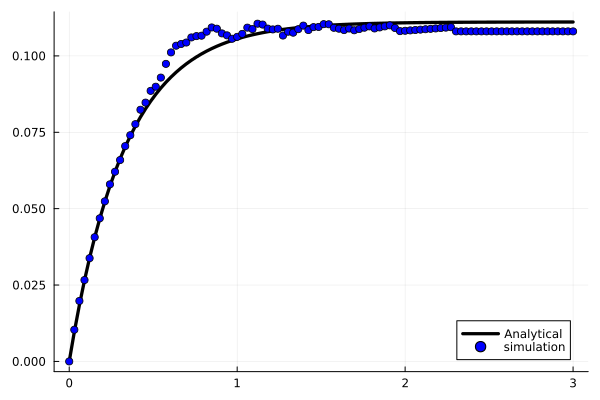

In [49]:
plot(t_given, f_analytical.(t_given), label="Analytical", color="black", linewidth=3.3)
scatter!(t_given, fi, label="simulation", color="blue")

# Resonance Fluorescene

# Observable Convergene

In [33]:
# System and parameters
H_rf = (delta::Float64, omega::Float64, k::Float64) ->  delta*[[0, 0] [0, 1.0+0im]]  + 0.5*omega*QuTaM.sigma_x
L_rf = (delta::Float64, omega::Float64, k::Float64) -> sqrt(k)*QuTaM.sigma_m
delta = 0.2
omega = 1.0
k = 0.5
function rf_de!(dr, r, p, t)
    dr[1] = -0.5*k*(1)*r[1] - delta*r[2]
    dr[2] = delta*r[1] - 0.5*k*(1)*r[2] - omega*r[3]
    dr[3] = omega*r[2] - k*(1)*r[3] - k
end
sys = System(H_rf(delta, omega, k), # Hamiltonian
[L_rf(delta, omega, k)]) #Jump Operators
tf = 40.0
params = SimulParameters(QuTaM.rf_psi0,
    tf, # Final time. Set very long so that all trajectories jump
    1, # seed
    1000, # Number of trajectories
    40_000, # Number of samples in the finegrid
    1.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
);

In [34]:
trajectories = run_trajectories(sys, params; progbar=true);

Sampling... 100%|██████████████████████████| Time: 0:00:52 (52.99 ms/it)


In [35]:
ntimes = 1000
t_given = collect(LinRange(0, params.tf, ntimes));

In [36]:
states = Array{ComplexF64}(undef, sys.NLEVELS, ntimes, params.ntraj)
r_sample = Array{Float64}(undef, ntimes, params.ntraj, 3)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]
for k in 1:params.ntraj
    states[:, :, k] = evaluate_at_t(t_given, trajectories[k], sys, params.psi0) 
end 

for l in 1:3
    for k in 1:params.ntraj
        for tn in 1:ntimes
            r_sample[tn, k, l] = dot(states[:, tn, k], sigma[l] * states[:, tn, k])
        end 
    end 
end 

r_avg = dropdims(mean(r_sample, dims=2),dims=2);

In [37]:
# Analytical Solution
r0 = [0.0, 0.0, 0.0]
for k in 1:3
    r0[k] = r_sample[1, 1, k]
end 
tspan = (0.0, params.tf)
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

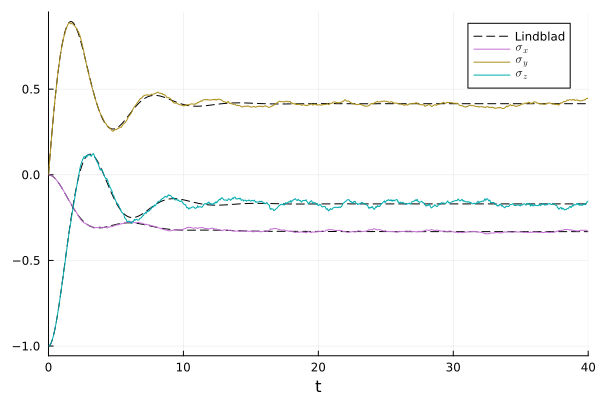

In [38]:
# Analytical Solutions 
plot(sol, idxs =(0, 1), seriescolor="black", label="Lindblad",  line=:dash)
plot!(sol, idxs =(0, 2), seriescolor="black", label=:false,  line=:dash)
plot!(sol, idxs =(0, 3), seriescolor="black", label=:false,  line=:dash)
# Simulation
plot!(t_given, r_avg[:, 1], label=L"\sigma_x" )
plot!(t_given, r_avg[:, 2], label=L"\sigma_y" )
plot!(t_given, r_avg[:, 3], label=L"\sigma_z" )


In [39]:
######### FISHER INFORMATION CALCULATION
t_given = collect(LinRange(0, params.tf, 100))
ntimes = size(t_given)[1]
effective_trajectories = params.ntraj
He_rf = GetHeffParametrized(H_rf, [L_rf])
xi_sample = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes, effective_trajectories)
for n in 1:effective_trajectories
    xi_sample[:, :, :, n] = MonitoringOperator(t_given, sys, He_rf, [L_rf], trajectories[n],
                             params.psi0,[delta, omega, k], [delta/100, 0.0 , 0.0])
end 
fi_sample = Array{Float64}(undef, ntimes, effective_trajectories)
for n in 1:effective_trajectories
    for k in 1:ntimes
       fi_sample[k, n] = ( real(tr(xi_sample[:, :, k, n])) )^2 
    end 
end 
fi = dropdims(mean(fi_sample, dims=2), dims=2);

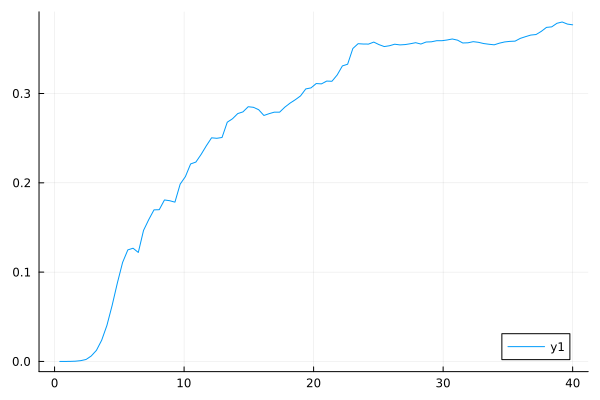

In [40]:
plot(t_given, fi./t_given)

In [6]:
function GetFI(delta::Float64)
    # System and parameters
    H_rf = (delta::Float64, omega::Float64, k::Float64) ->  delta*[[0, 0] [0, 1.0+0im]]  + 0.5*omega*QuTaM.sigma_x
    L_rf = (delta::Float64, omega::Float64, k::Float64) -> sqrt(k)*QuTaM.sigma_m
    He_rf = GetHeffParametrized(H_rf, [L_rf])
    omega = 1.0
    k = 0.5
    sys = System(H_rf(delta, omega, k), # Hamiltonian
    [L_rf(delta, omega, k)]) #Jump Operators
    tf = 40.0
    params = SimulParameters(QuTaM.rf_psi0,
        tf, # Final time. Set very long so that all trajectories jump
        1, # seed
        500, # Number of trajectories
        40_000, # Number of samples in the finegrid
        1.0, # Multiplier to use in the fine grid
        1e-3 # Tolerance for passing Dark state test
    )
    trajectories = run_trajectories(sys, params; progbar=false);
    t_given = [tf];
    ntimes = size(t_given)[1]
    xi_sample = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes, params.ntraj)
    for n in 1:params.ntraj
        xi_sample[:, :, :, n] = MonitoringOperator(t_given, sys, He_rf, [L_rf], trajectories[n],
                                 params.psi0,[delta, omega, k], [delta/100, 0.0, 0.0])
    end 
    fi_sample = Array{Float64}(undef, ntimes, params.ntraj)
    for n in 1:params.ntraj
        for k in 1:ntimes
           fi_sample[k, n] = real(tr(xi_sample[:, :, k, n]))^2 
        end 
    end 
    fi = dropdims(mean(fi_sample, dims=2), dims=2)[1]
    return fi/tf
end 

GetFI (generic function with 1 method)

In [9]:
using Base.Threads
ndeltas = 100
delta_range = collect(LinRange(0.01, 1.5, ndeltas))
fi_t = Array{Float64}(undef, ndeltas)
@showprogress @threads for n in 1:ndeltas
    fi_t[n] = GetFI(delta_range[n])
end 

Progress: 100%|█████████████████████████████████████████| Time: 0:30:21


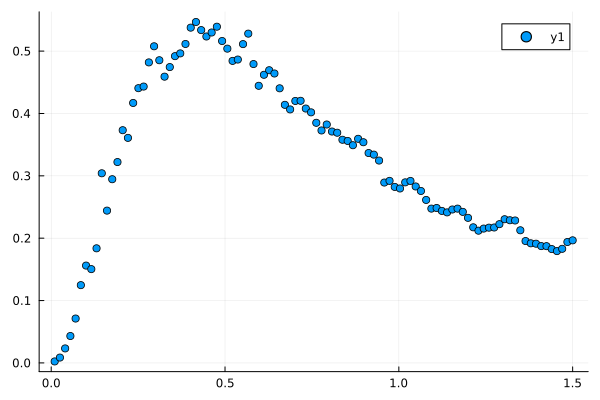

In [20]:
scatter(delta_range, fi_t, line=:dash)

In [24]:
df = DataFrame([delta_range, fi_t], :auto)
CSV.write("preliminary1.csv", df)

"preliminary1.csv"

In [48]:
function GetFI_(delta::Float64, alpha::Float64)
    # System and parameters
    L_rf = (delta::Float64, omega::Float64, k::Float64) -> sqrt(k)*QuTaM.sigma_m + alpha*I
    H_rf = (delta::Float64, omega::Float64, k::Float64) -> begin
                                delta*[[0, 0] [0, 1.0+0im]]  + 0.5*omega*QuTaM.sigma_x -0.5im*(conj(alpha).*L_rf(delta, omega, k) -
                                                                                                alpha.*adjoint(L_rf(delta, omega, k)))
                                                            end 
    He_rf = GetHeffParametrized(H_rf, [L_rf])
    omega = 1.0
    k = 0.5
    sys = System(H_rf(delta, omega, k), # Hamiltonian
    [L_rf(delta, omega, k)]) #Jump Operators
    tf = 40.0
    params = SimulParameters(QuTaM.rf_psi0,
        tf, # Final time. Set very long so that all trajectories jump
        1, # seed
        500, # Number of trajectories
        40_000, # Number of samples in the finegrid
        1.0, # Multiplier to use in the fine grid
        1e-3 # Tolerance for passing Dark state test
    )
    trajectories = run_trajectories(sys, params; progbar=false);
    t_given = [tf];
    ntimes = size(t_given)[1]
    xi_sample = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes, params.ntraj)
    for n in 1:params.ntraj
        xi_sample[:, :, :, n] = MonitoringOperator(t_given, sys, He_rf, [L_rf], trajectories[n],
                                 params.psi0,[delta, omega, k], [delta/100, 0.0, 0.0])
    end 
    fi_sample = Array{Float64}(undef, ntimes, params.ntraj)
    for n in 1:params.ntraj
        for k in 1:ntimes
           fi_sample[k, n] = real(tr(xi_sample[:, :, k, n]))^2 
        end 
    end 
    fi = dropdims(mean(fi_sample, dims=2), dims=2)[1]
    return fi/tf
end 

GetFI_ (generic function with 1 method)

In [50]:
GetFI_(0.2, 0.0)

0.3520647113013056

In [51]:
GetFI_(0.2, 1.3 )

0.4569231462773744

In [ ]:
GetFI_(0.2, 10.3 )

In [ ]:
GetFI_(0.2, 50.3 )